In [ ]:
import sys
from pathlib import Path
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))
from utils import show_classification_report, random_over_sample, random_under_sample, smote_over_sample, tomek_under_sample, SampledDataset, plot_feature_importances

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
import pandas as pd
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical


# Load Dataset 

In [7]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full2.parquet')
dataset.drop(columns=['lon', 'lat'], inplace=True, errors='ignore')

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])


X_df = dataset.drop('fire', axis=1)
X_string_columns = X_df.select_dtypes(include=['object']).columns
X_df[X_string_columns] = OrdinalEncoder().fit_transform(X_df[X_string_columns])

Y_df = dataset['fire']

print("=== X columns:\n", X_df.dtypes)

=== X columns:
 log_precip_s1             float64
log_precip_s2             float64
log_precip_s3             float64
log_precip_s4             float64
tmax_s1                   float64
tmax_s2                   float64
tmax_s3                   float64
tmax_s4                   float64
amplitude_thermique_s1    float64
amplitude_thermique_s2    float64
amplitude_thermique_s3    float64
amplitude_thermique_s4    float64
GRIDCODE                  float64
log_area_sqm              float64
lcc_code_encoded          float64
elevation                 float32
COARSE                    float64
SAND                      float64
SILT                      float64
CLAY                      float64
TEXTURE_USDA              float64
TEXTURE_SOTER             float64
BULK                      float64
REF_BULK                  float64
ORG_CARBON                float64
PH_WATER                  float64
TOTAL_N                   float64
CN_RATIO                  float64
CEC_SOIL                  float6

# Util Functions

In [4]:
sampled_dataset = SampledDataset(["Original", "Random Over-Sampling", "Random Under-Sampling", "SMOTE Over-Sampling", "Tomek Links Under-Sampling"])

def main(X_df, Y_df):
    _X_np_train, _X_np_test, _Y_np_train, _Y_np_test = train_test_split(
        X_df.to_numpy(), Y_df.to_numpy(),
        test_size=0.2,      # 20% test
        random_state=42,    # for reproducibility
        shuffle=True        # default True
    )
    model = DecisionTreeClassifier(random_state=42)
    model.fit(_X_np_train, _Y_np_train)
    Y_pred = model.predict(_X_np_test)
    metrics = show_classification_report(_Y_np_test, Y_pred)

    sampled_dataset.go_next_method(_X_np_train, _Y_np_train, _X_np_test, _Y_np_test, metrics.roc_auc)

# Finding Best Sampling Method

Original dataset:
Accuracy  : 0.9413  (maximize)
Precision : 0.8721  (maximize)
Recall    : 0.9027  (maximize)
F1 Score  : 0.8871  (maximize)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8465
           1       0.87      0.90      0.89      2908

    accuracy                           0.94     11373
   macro avg       0.92      0.93      0.92     11373
weighted avg       0.94      0.94      0.94     11373



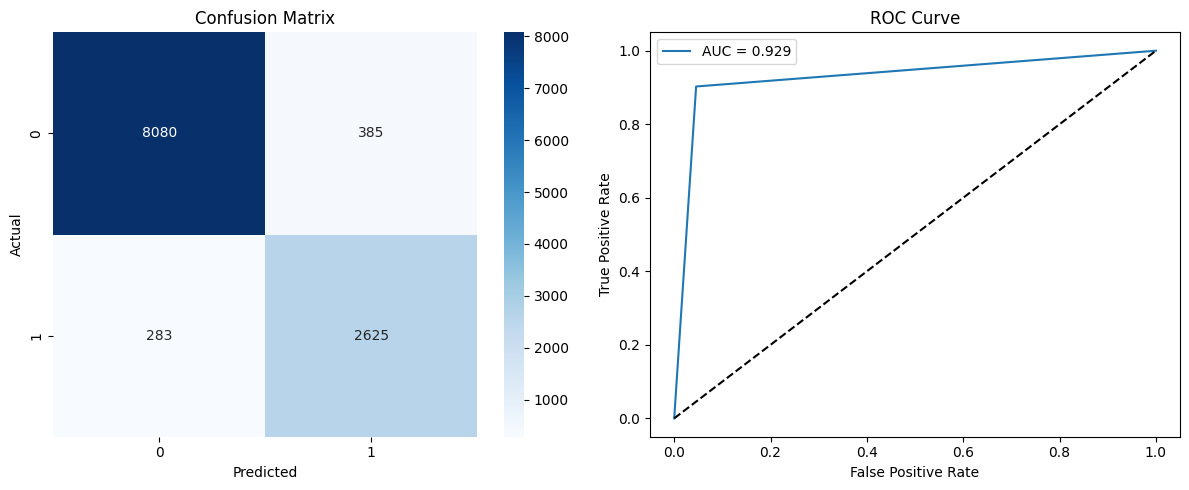

Random Over-Sampling:
Accuracy  : 0.9725  (maximize)
Precision : 0.9537  (maximize)
Recall    : 0.9930  (maximize)
F1 Score  : 0.9730  (maximize)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      8494
           1       0.95      0.99      0.97      8461

    accuracy                           0.97     16955
   macro avg       0.97      0.97      0.97     16955
weighted avg       0.97      0.97      0.97     16955



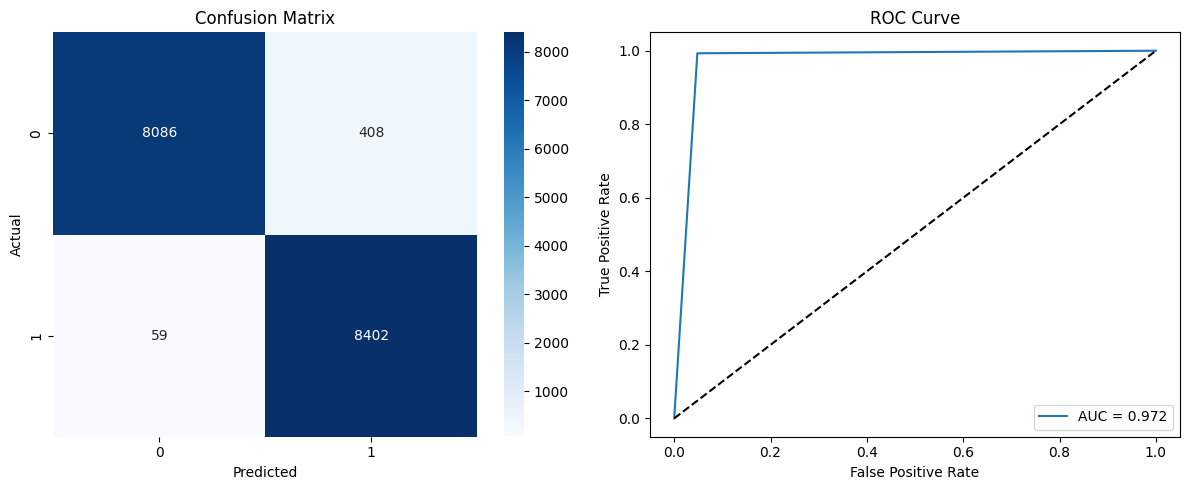

Random Under-Sampling:
Accuracy  : 0.9278  (maximize)
Precision : 0.9183  (maximize)
Recall    : 0.9403  (maximize)
F1 Score  : 0.9292  (maximize)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2876
           1       0.92      0.94      0.93      2915

    accuracy                           0.93      5791
   macro avg       0.93      0.93      0.93      5791
weighted avg       0.93      0.93      0.93      5791



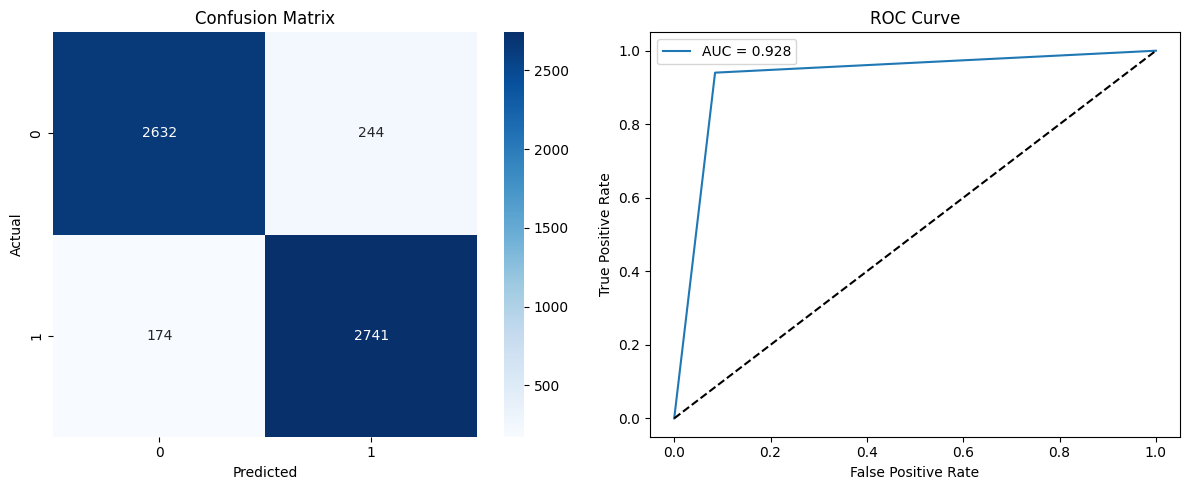

SMOTE Over-Sampling:
Accuracy  : 0.9476  (maximize)
Precision : 0.9428  (maximize)
Recall    : 0.9525  (maximize)
F1 Score  : 0.9476  (maximize)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      8509
           1       0.94      0.95      0.95      8446

    accuracy                           0.95     16955
   macro avg       0.95      0.95      0.95     16955
weighted avg       0.95      0.95      0.95     16955



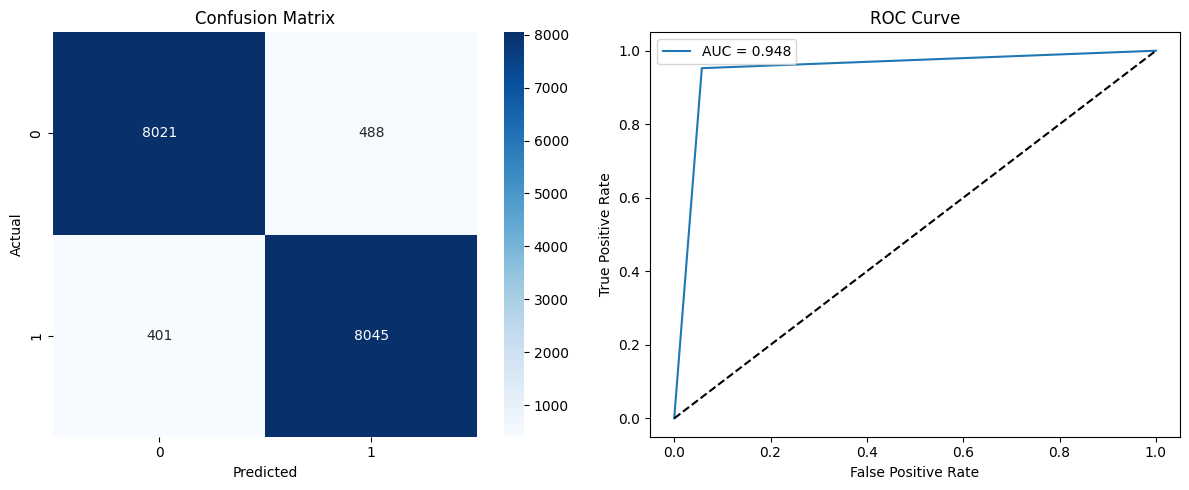

Tomek Links Under-Sampling:
Accuracy  : 0.9461  (maximize)
Precision : 0.8796  (maximize)
Recall    : 0.9188  (maximize)
F1 Score  : 0.8988  (maximize)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      8288
           1       0.88      0.92      0.90      2918

    accuracy                           0.95     11206
   macro avg       0.93      0.94      0.93     11206
weighted avg       0.95      0.95      0.95     11206



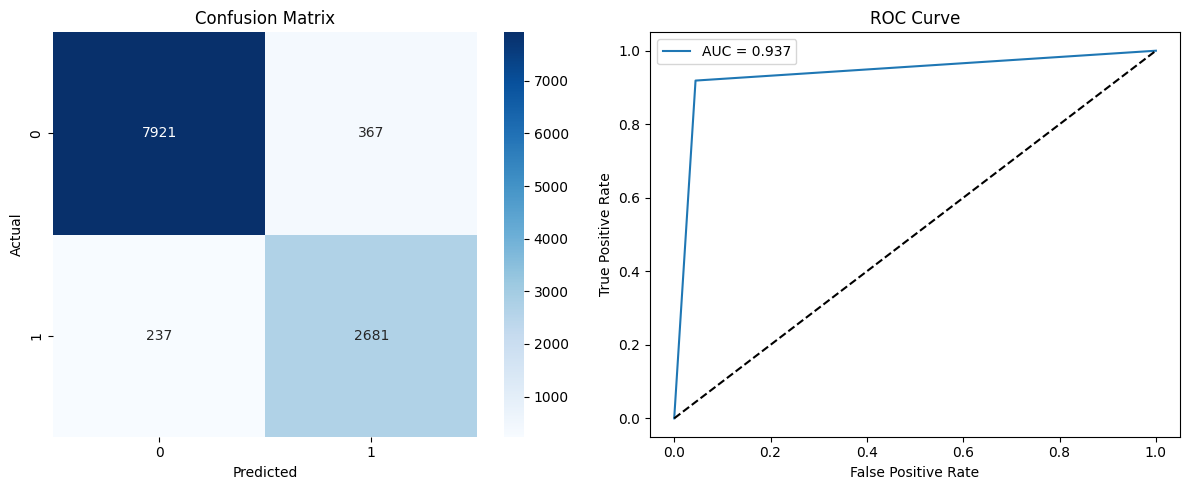

Best sampling method: Random Over-Sampling with ROC AUC: 0.9725
New dataset sizes: Train=67819, Test=16955, Full=84774
Class distribution: class 0: 33893, class 1: 33926


In [5]:
print("Original dataset:")
main(X_df, Y_df)
print("Random Over-Sampling:")
main(*random_over_sample(X_df, Y_df))
print("Random Under-Sampling:")
main(*random_under_sample(X_df, Y_df))
print("SMOTE Over-Sampling:")
main(*smote_over_sample(X_df, Y_df))
print("Tomek Links Under-Sampling:")
main(*tomek_under_sample(X_df, Y_df))

sampled_dataset.print_report("ROC AUC")
X_np_train = sampled_dataset.best_X_train
Y_np_train = sampled_dataset.best_y_train
X_np_test = sampled_dataset.best_X_test
Y_np_test = sampled_dataset.best_y_test

# Parameter Tuning

In [ ]:

search_space = {
    "max_depth": Integer(1, 50),
    "min_samples_split": Integer(2, 50),
    "min_samples_leaf": Integer(1, 50),
    "max_features": Categorical([None, "sqrt", "log2"]),
    "criterion": Categorical(["gini", "entropy"]),
}

dt = DecisionTreeClassifier(random_state=42)

bayes = BayesSearchCV(
    estimator=dt,
    search_spaces=search_space,
    n_iter=50,           # number of evaluations
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42,
)

bayes.fit(X_np_train, Y_np_train)

best_model = bayes.best_estimator_
print(bayes.best_params_)
plot_feature_importances(best_model, X_df.columns, top_n=10)

OrderedDict([('ccp_alpha', 1e-06), ('criterion', 'gini'), ('max_depth', 39), ('max_features', None), ('min_samples_leaf', 1), ('min_samples_split', 2)])


# Testing with Best Parameters

Accuracy  : 0.9725  (maximize)
Precision : 0.9537  (maximize)
Recall    : 0.9930  (maximize)
F1 Score  : 0.9730  (maximize)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      8494
           1       0.95      0.99      0.97      8461

    accuracy                           0.97     16955
   macro avg       0.97      0.97      0.97     16955
weighted avg       0.97      0.97      0.97     16955



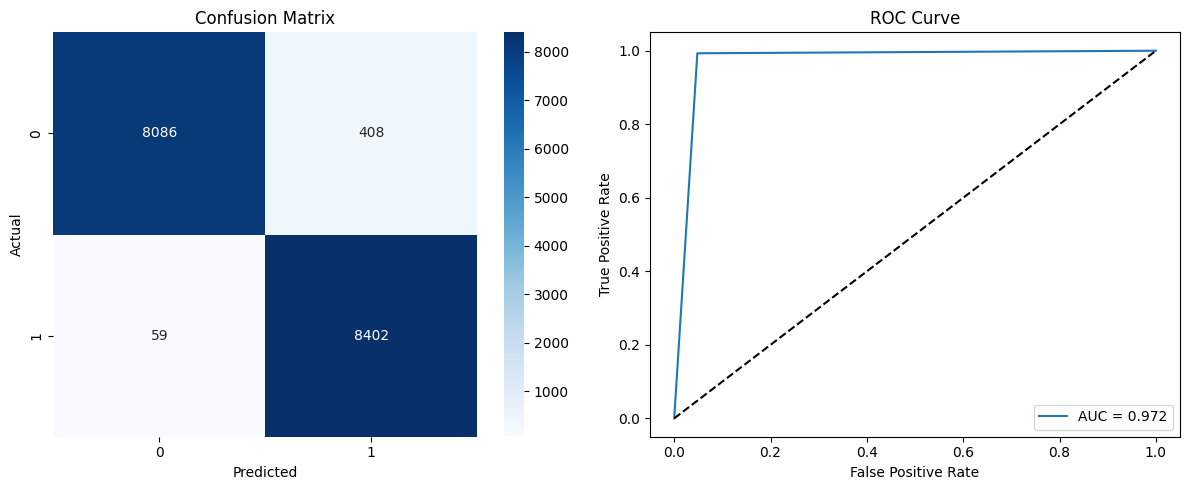

In [6]:
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=39, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
decision_tree.fit(X_np_train, Y_np_train)
Y_pred = decision_tree.predict(X_np_test)
show_classification_report(Y_np_test, Y_pred)

# Dimensionality Reduction

In [5]:
pca = PCA(n_components=0.9)
X_np_train_pca = pca.fit_transform(X_np_train)
X_np_test_pca = pca.transform(X_np_test)

print("Old number of features before PCA:", X_np_train.shape[1])
print("New number of features after PCA:", X_np_train_pca.shape[1])


Old number of features before PCA: 38
New number of features after PCA: 1


# Parameter Tuning after Dimensionality Reduction

In [ ]:

search_space = {
    "max_depth": Integer(1, 50),
    "min_samples_split": Integer(2, 50),
    "min_samples_leaf": Integer(1, 50),
    "max_features": Categorical([None, "sqrt", "log2"]),
    "criterion": Categorical(["gini", "entropy"]),
}

dt = DecisionTreeClassifier(random_state=42)

bayes = BayesSearchCV(
    estimator=dt,
    search_spaces=search_space,
    n_iter=50,           # number of evaluations
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42,
)

bayes.fit(X_np_train_pca, Y_np_train)

best_model_pca = bayes.best_estimator_
print(bayes.best_params_)
plot_feature_importances(best_model_pca, [f"PC{i+1}" for i in range(X_np_train_pca.shape[1])], top_n=10)


OrderedDict([('criterion', 'gini'), ('max_depth', 50), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 2)])


# Testing with Dimensionality Reduction

Accuracy  : 0.9434  (maximize)
Precision : 0.9109  (maximize)
Recall    : 0.9827  (maximize)
F1 Score  : 0.9455  (maximize)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8494
           1       0.91      0.98      0.95      8461

    accuracy                           0.94     16955
   macro avg       0.95      0.94      0.94     16955
weighted avg       0.95      0.94      0.94     16955



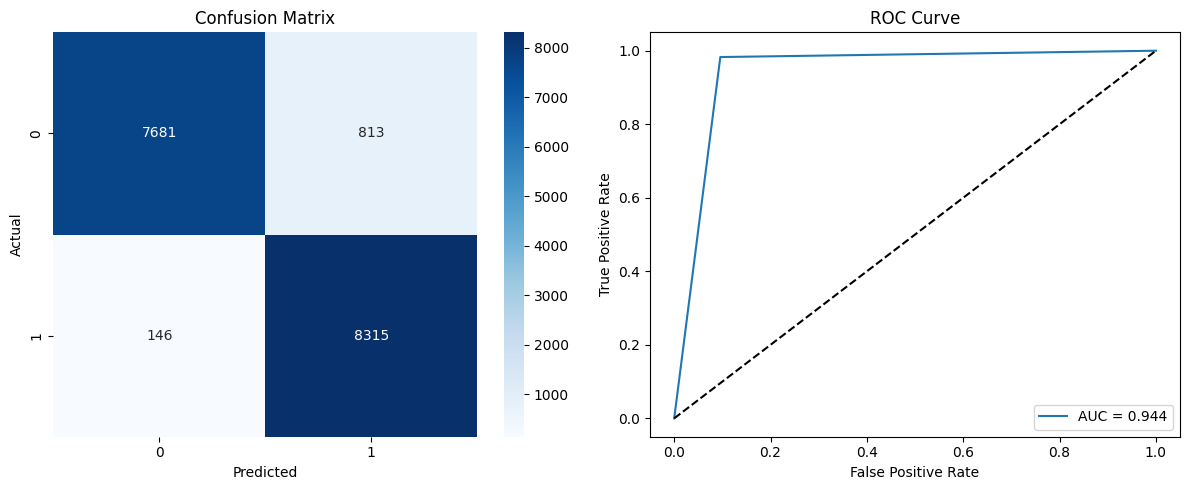

In [10]:

best_model_pca.fit(X_np_train_pca, Y_np_train)
Y_pred = best_model_pca.predict(X_np_test_pca)
show_classification_report(Y_np_test, Y_pred)

# Scartch Decision Tree

In [ ]:
import numpy as np

class ScratchDecisionTreeClassifier:
    def __init__(
        self,
        criterion="gini",
        max_depth=50,
        min_samples_split=2,
        min_samples_leaf=1
    ):
        assert criterion in ("gini", "entropy")
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf


    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)

        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_in_ = X.shape[1]

        self._class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_idx = np.array([self._class_to_index[c] for c in y])

        self.tree_ = self._build_tree(X, y_idx, depth=0)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.array([self.classes_[self._predict_one(x)] for x in X])

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        return np.array([self._predict_proba_one(x) for x in X])

    def score(self, X, y):
        return np.mean(self.predict(X) == y)


    class Node:
        def __init__(self, *, feature=None, threshold=None, left=None, right=None, proba=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.proba = proba

        @property
        def is_leaf(self):
            return self.proba is not None


    def _build_tree(self, X, y, depth):
        n_samples = len(y)

        if (
            n_samples < self.min_samples_split
            or len(np.unique(y)) == 1
            or (self.max_depth is not None and depth >= self.max_depth)
        ):
            return self._make_leaf(y)

        split = self._best_split(X, y)
        if split is None:
            return self._make_leaf(y)

        feature, threshold, left_idx, right_idx = split

        return self.Node(
            feature=feature,
            threshold=threshold,
            left=self._build_tree(X[left_idx], y[left_idx], depth + 1),
            right=self._build_tree(X[right_idx], y[right_idx], depth + 1),
        )


    def _best_split(self, X, y):
        best_gain = 0.0
        best_split = None
        parent_impurity = self._impurity(y)

        n_samples, n_features = X.shape

        for feature in range(n_features):
            values = X[:, feature]
            unique_vals = np.unique(values)

            if len(unique_vals) <= 1:
                continue

            # Proper threshold candidates (midpoints)
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2.0

            for t in thresholds:
                left = np.where(values <= t)[0]
                right = np.where(values > t)[0]

                if (
                    len(left) < self.min_samples_leaf
                    or len(right) < self.min_samples_leaf
                ):
                    continue

                gain = parent_impurity - self._weighted_impurity(
                    [y[left], y[right]]
                )

                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature, t, left, right)

        return best_split


    def _impurity(self, y):
        counts = np.bincount(y, minlength=self.n_classes_)
        probs = counts / counts.sum()

        if self.criterion == "gini":
            return 1.0 - np.sum(probs ** 2)

        return -np.sum(p * np.log2(p) for p in probs if p > 0)

    def _weighted_impurity(self, groups):
        total = sum(len(g) for g in groups)
        return sum((len(g) / total) * self._impurity(g) for g in groups)


    def _make_leaf(self, y):
        counts = np.bincount(y, minlength=self.n_classes_)
        proba = counts / counts.sum()
        return self.Node(proba=proba)

    def _predict_one(self, x):
        node = self.tree_
        while not node.is_leaf:
            node = node.left if x[node.feature] <= node.threshold else node.right
        return np.argmax(node.proba)

    def _predict_proba_one(self, x):
        node = self.tree_
        while not node.is_leaf:
            node = node.left if x[node.feature] <= node.threshold else node.right
        return node.proba


# Testing with Best Parameters (with 20 components)

In [10]:
pca = PCA(n_components=20)
X_np_train_reduced = pca.fit_transform(X_np_train)
X_np_test_reduced = pca.transform(X_np_test)

print("Old number of features before PCA:", X_np_train.shape[1])
print("New number of features after PCA:", X_np_train_reduced.shape[1])

Old number of features before PCA: 38
New number of features after PCA: 20


Accuracy  : 0.9679  (maximize)
Precision : 0.9463  (maximize)
Recall    : 0.9920  (maximize)
F1 Score  : 0.9686  (maximize)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      8494
           1       0.95      0.99      0.97      8461

    accuracy                           0.97     16955
   macro avg       0.97      0.97      0.97     16955
weighted avg       0.97      0.97      0.97     16955



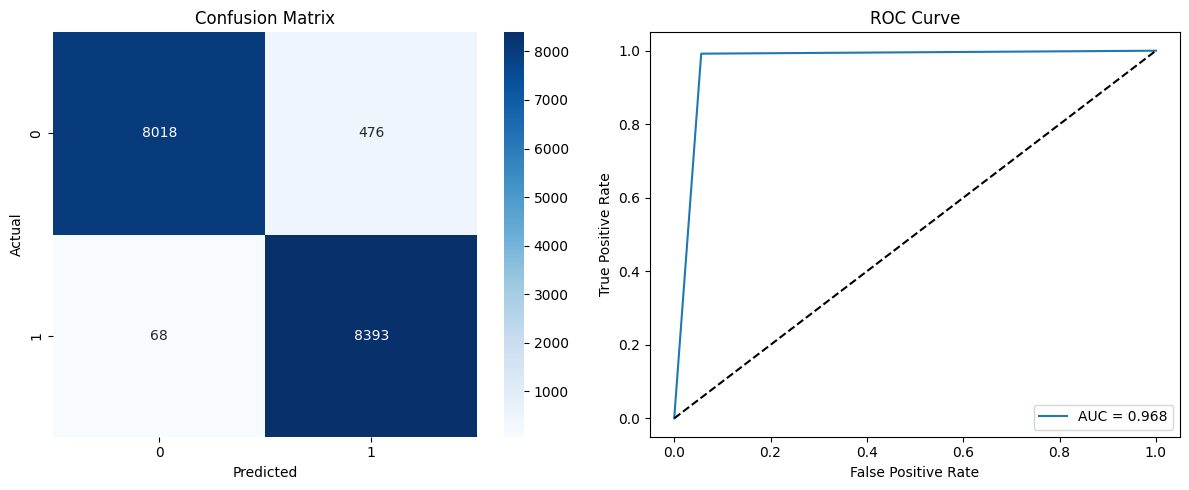

In [11]:

scratch_decision_tree = ScratchDecisionTreeClassifier()
scratch_decision_tree.fit(X_np_train_reduced, Y_np_train)
Y_pred = scratch_decision_tree.predict(X_np_test_reduced)
show_classification_report(Y_np_test, Y_pred)

# Testing with Best Parameters after Dimensionality Reduction

Accuracy  : 0.9441  (maximize)
Precision : 0.9116  (maximize)
Recall    : 0.9833  (maximize)
F1 Score  : 0.9461  (maximize)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8494
           1       0.91      0.98      0.95      8461

    accuracy                           0.94     16955
   macro avg       0.95      0.94      0.94     16955
weighted avg       0.95      0.94      0.94     16955



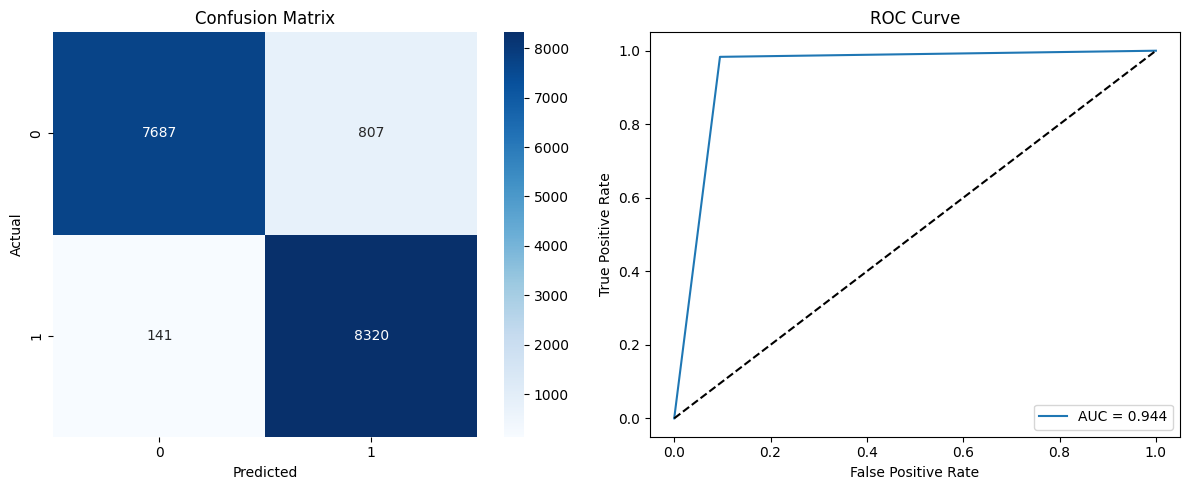

In [8]:
scratch_decision_tree = ScratchDecisionTreeClassifier()
scratch_decision_tree.fit(X_np_train_pca, Y_np_train)
Y_pred = scratch_decision_tree.predict(X_np_test_pca)
show_classification_report(Y_np_test, Y_pred)